In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'skin-cancer-mnist-ham10000:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F54339%2F104884%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T034449Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4e081ce8d66793dcf4dd5c9ecfc2978506959706ec9536572baa8147fcdfa685ad2e6b0ef071be77f31204acc13f74522f5d6f3e90e1ac7f668a721975a9031e47a1a34fd0d171ae23ff04a9f76cf72b94a66be2ac3693eb14c25d3159891ce372955c6fcddff6b9e6a1a80a6ef3aa3d6c834b4f85ca76bd4e0061d23dda4e6b61e1f4c7446765e79fdbb97e568013204c2c1d619afe2fccf30ba5b75f04355e2747b33f6bd1e46275190be53a2d47f8c7e77cecc2a11a821a5e74fef872226e35623fb053e6e09b7d7f5bc7d2d74216dadbb72981beb81ab65e2f7df1407fe329300d7851bd4df602b506288f6bd2e2035cb9a12aa656983e6520179547ac86'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5582914511 bytes downloaded
Downloaded and uncompressed: skin-cancer-mnist-ham10000
Data source import complete.


# Here we are going to use Fastai to classify skin lesion.

### For now let's rely only on the images for classification.

### Let's start with basic imports.

In [2]:
import fastai
import pandas as pd
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.data.all import *

### Read in metadata.

In [3]:
csv_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
skin_df = pd.read_csv(csv_path)
skin_df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


### Translate shortcuts of diseases to english.

In [4]:
short_to_full_name_dict = {
    "akiec" : "Bowen's disease", # very early form of skin cancer
    "bcc" : "basal cell carcinoma" , # basal-cell cancer or white skin cancer
    "bkl" : "benign keratosis-like lesions", # non-cancerous skin tumour
    "df" : "dermatofibroma", # non-cancerous rounded bumps
    "mel" : "melanoma", # black skin cancer
    "nv" : "melanocytic nevi", # mole non-cancerous
    "vasc" : "vascular lesions", # skin condition
}

### Let's create a dictionary, mapping each image id to a disease.

In [5]:
img_to_class_dict = skin_df.loc[:, ["image_id", "dx"]] # returns only dx and image id column
img_to_class_dict = img_to_class_dict.to_dict('list')  # returns columns as lists in a dict
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) } # returns a dict mapping image id to disease name
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'benign keratosis-like lesions'),
 ('ISIC_0025030', 'benign keratosis-like lesions'),
 ('ISIC_0026769', 'benign keratosis-like lesions'),
 ('ISIC_0025661', 'benign keratosis-like lesions'),
 ('ISIC_0031633', 'benign keratosis-like lesions')]

### Create a function for getting the label.
### Create a Datablock and specify Data Augmentation and 70/30 train/validation split.
### Then create the dataloader itself that gets passed to the model/learner.

In [6]:
def get_label_from_dict(path):
    return img_to_class_dict[path.stem] # path.stem returns the filename without suffix

skin_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # independent variable x is an image | dependent variabley is a category
    item_tfms=[Resize(450), DihedralItem()], # DihedralItem all 4 90 deg roatations and for each: 2 horizonntal flips -> 8 orientations
    batch_tfms=RandomResizedCrop(size=224, min_scale=0.75, max_scale=1.0), # Picks a random scaled crop of an image and resize it to size
    get_items=get_image_files, # returns all images found in a folder and its subfolders
    splitter=RandomSplitter(valid_pct=0.3, seed=42), # splits the the data in train and valid 70/30
    get_y=get_label_from_dict, # specifies how to get the label of an image
)

img_path = "/kaggle/input/skin-cancer-mnist-ham10000"
# skin_db.summary(img_path) # for debugging
dls = skin_db.dataloaders(img_path, bs=16) # create dataloader using img_path

### Display some images with labels

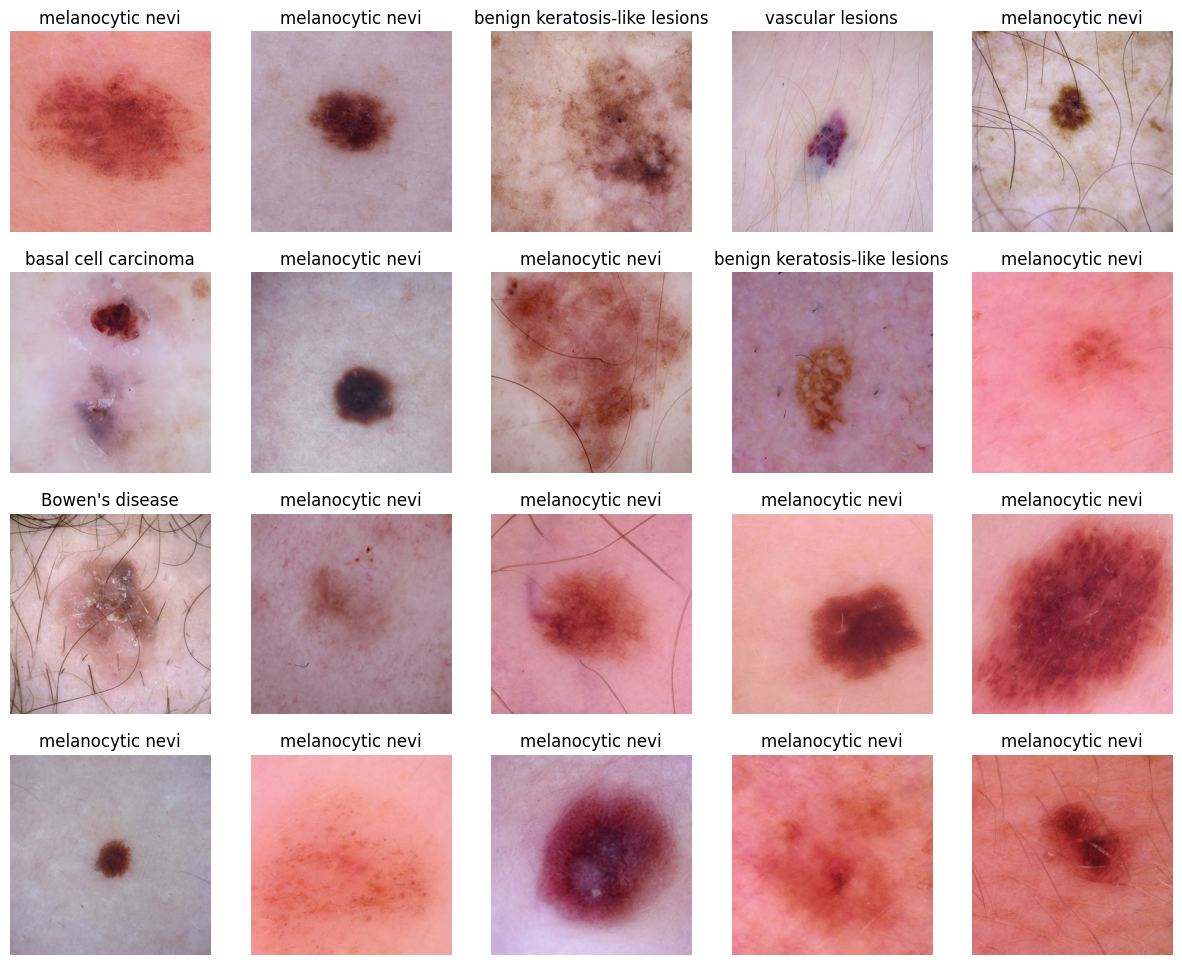

In [8]:
dls.show_batch(max_n=20, nrows=4) # show a batch of images with labels

### Create learner with ResNet18 (pretrained), and specify optimizer as ranger.
### Transfer learning with Mix up for 33 epochs.

Mix up is a very powerful technique that lets two images overlap and the corresponding one hot encoded label is no longer e.g. (0,0,0,1) it may be (0,0,0.5,0.5).
So maybe 50% cat and 50 % dog.

This is one of the most effective data augmentation techniques that is very good in stopping overfitting, but typically requires a lot of epochs to be worth it.
Especially for small datasets and top tier results mix up can be very helpful.

In [22]:
learn = vision_learner(dls, resnet18, metrics=accuracy, opt_func=ranger)
learn.fine_tune(epochs=30, freeze_epochs=3, base_lr=0.005, cbs=MixUp(0.5)) # use mixup with callbacks

OutOfMemoryError: Exception occured in `TrainEvalCallback` when calling event `before_fit`:
	CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 2298 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 356.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)